# Prediction Model for Autism using Simple Machine Learning and fMRIs

first we import all the libraries:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from nilearn import plotting
from nilearn import datasets
import os

## The Harvard-Oxford Atlas
The Harvard-Oxford Atlas is a well-known probabilistic brain atlas used in neuroimaging. As it's name suggests it was developed by a collaboration between Oxford and Harvard univerisities. In neuroimaging software like FSL (FMRIB Software Library), the Harvard-Oxford Atlas is often used for automated brain region labeling and analysis.

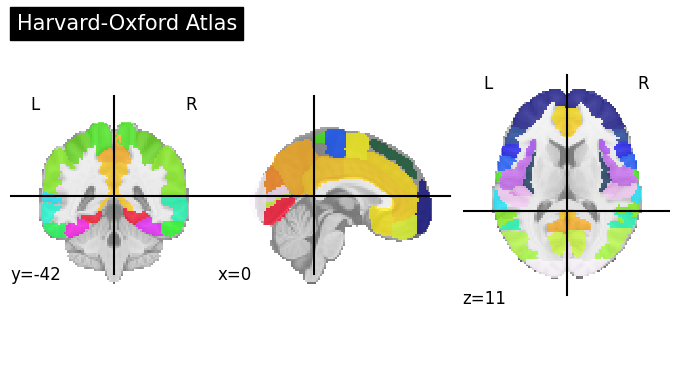

In [3]:
## A demo of the Atlas:

dataset_ho = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm")
atlas_ho_filename = dataset_ho.filename
plotting.plot_roi(atlas_ho_filename, title="Harvard-Oxford Atlas")

## Blood-Oxygen-Level-Dependent
It refers to a method used in functional MRI (fMRI) to measure brain activity. BOLD fMRI detects changes in blood flow and oxygen levels in the brain, which occur in response to neural activity. When a brain region becomes more active, it consumes more oxygen, and BOLD fMRI captures these changes to map and understand brain function

The following graph represents BOLD signals of subject number 1 from each of Normal and ASD people. 

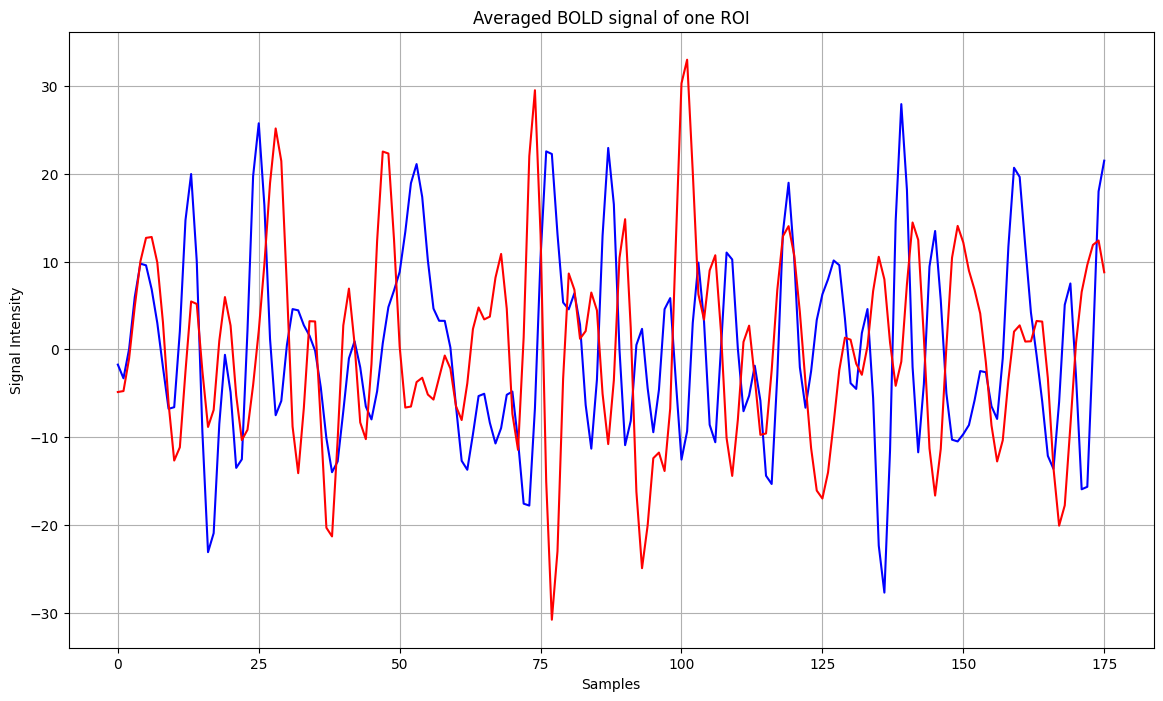

In [4]:
dataASD=pd.read_csv('Training Data\\ASD\\ASD Subject 01.csv')
dataNormal=pd.read_csv('Training Data/Normal/Normal Subject 02.csv')
dfASD=dataASD.drop(columns='Unnamed: 0')
dfNormal=dataNormal.drop(columns='Unnamed: 0')
plt.figure(figsize=[14,8])
plt.plot(dfNormal.iloc[:,1],color="blue")
plt.plot(dfASD.iloc[:,1],color="red")
plt.xlabel("Samples")
plt.ylabel("Signal Intensity")
plt.title("Averaged BOLD signal of one ROI")
plt.grid()
plt.show()

## Loading the Data
the next cell saves the path to each folder contaning the CSV file to each type

In [5]:
current_dir = os.getcwd()

ASD_relative_path = "Training Data\\ASD"
Normal_relative_path = "Training Data\\Normal"


ASD_samples_path = os.path.join(current_dir, ASD_relative_path)
Normal_samples_path = os.path.join(current_dir, Normal_relative_path)

The next cell tries to merge all the data in a pandas dataframe. Each row should represent the Subject and all the recorded data in his CSV file

In [6]:
def load_csv_files(folder_path):
    """Loads CSV files from a specified folder and returns a list of DataFrames.

    Args:
        folder_path (str): Path to the folder containing CSV files.

    Returns:
        list: A list of DataFrames, one for each CSV file in the folder.
    """

    samples = []
    label = 1 if "ASD" in folder_path else 0  # Determine label based on folder name
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            filepath = os.path.join(folder_path, filename)
            df = pd.read_csv(filepath)
            df['label'] = label  # Add label column to DataFrame
            samples.append(df.values.flatten().tolist())  # Flatten the 2D array to 1D list

            # Add the new column
            num_rows = df.shape[0]
            half_rows = num_rows // 2
            new_column_values = np.concatenate([np.zeros(half_rows), np.ones(half_rows)])
            df['new_column'] = pd.Series(new_column_values)
    return samples

ASD = load_csv_files(ASD_relative_path)
Normal = load_csv_files(Normal_relative_path)
training_samples = ASD + Normal
training_samples = np.array(training_samples)
training_samples = pd.DataFrame(training_samples)

In [7]:
num_rows = training_samples.shape[0]
half_rows = num_rows // 2

# Create a Series with the desired values
new_column_values = np.concatenate([np.zeros(half_rows), np.ones(half_rows)])

# Add the Series as a new column to the DataFrame
training_samples['target'] = pd.Series(new_column_values)

In [8]:
training_samples.target = training_samples.target.astype(int)

In [9]:
training_samples.drop(0,axis= 1, inplace= True)

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

X = training_samples.drop('target', axis=1)  # Features
y = training_samples['target']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA to reduce the number of features
pca = PCA(n_components=0.95)  # 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Feature selection using SelectKBest
selector = SelectKBest(score_func=mutual_info_classif, k=100)  # Adjust k based on feature selection
X_train_selected = selector.fit_transform(X_train_pca, y_train)
X_test_selected = selector.transform(X_test_pca)

# Train a Random Forest model with controlled complexity
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)  # Adjust parameters as needed
model.fit(X_train_selected, y_train)

# Cross-validation to evaluate the model
cv_scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='accuracy', n_jobs=-1)  # Parallelize
print("Cross-Validation Accuracy:", cv_scores.mean())

# Make predictions on the testing set
y_pred = model.predict(X_test_selected)

C:\Users\youss\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=63. All the features will be returned.
  warnings.warn(


Cross-Validation Accuracy: 0.8857142857142858


In [11]:
# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", accuracy)


Test Set Accuracy: 0.9
